# Capítulo 5 – Detección de Anomalías con Autoencoders

En este capítulo se introduce el enfoque de **Autoencoders**, uno de los primeros modelos de **Deep Learning** aplicados a la detección de anomalías.  

Su principal fortaleza radica en que **aprenden una representación comprimida (codificación) de los datos normales y luego intentan reconstruirlos**.  
Cuando el modelo encuentra un dato anómalo —algo que no encaja en el patrón aprendido— el **error de reconstrucción** tiende a ser mayor, lo que permite identificar la anomalía.

## Motivación

La elección de Autoencoders responde a varias razones:

- Modelan **relaciones no lineales complejas** en los datos.  
- No requieren etiquetas, únicamente muestras representativas del comportamiento normal.  
- Permiten incorporar **estructuras temporales** (ventanas deslizantes o variantes recurrentes).  
- Funcionan como paso previo a arquitecturas más avanzadas, como los **LSTM Autoencoders**.  
- Representan una primera aproximación a las capacidades del **Deep Learning** en el campo de la detección de anomalías.

## Intuición

El Autoencoder es una red neuronal formada por dos componentes:

- **Encoder**: reduce la dimensionalidad de los datos, generando una representación latente.  
- **Decoder**: reconstruye los datos originales a partir de dicha representación.  

De forma intuitiva:

> Un Autoencoder aprende a copiar los datos normales. Cuando recibe un patrón desconocido o anómalo, no consigue reconstruirlo con precisión y el error de reconstrucción se incrementa.

## Fundamento teórico

El entrenamiento de un Autoencoder se plantea como la minimización del error de reconstrucción:

$$
\min_{\theta} L(x, g_{\theta}(f_{\theta}(x)))
$$

donde:

- $f_{\theta}(x)$: función de codificación (encoder).  
- $g_{\theta}(z)$: función de decodificación (decoder).  
- $L(\cdot)$: función de pérdida, habitualmente el **MSE** (Mean Squared Error).  

El score de anomalía para un punto $x$ se define como:

$$
s(x) = \|x - \hat{x}\|^2
$$

Si $s(x)$ supera un umbral definido, el punto se clasifica como anómalo.

## Función de decisión y scores

- **Salida del modelo**: reconstrucción $\hat{x}$ de la entrada $x$.  
- **Score de anomalía**: error de reconstrucción.  
  - Valores bajos → dato normal.  
  - Valores altos → potencial anomalía.

## Parámetros clave

- Dimensión del espacio latente.  
- Número de capas y neuronas en la red.  
- Funciones de activación (ReLU, tanh, etc.).  
- Función de pérdida (MSE, MAE o variantes robustas).  
- Regularización (dropout, weight decay, sparsity).  


## Implementación de un Autoencoder básico

A continuación construiremos un Autoencoder sencillo y lo probaremos en distintos escenarios.  
El objetivo es ver de manera intuitiva:

- Cómo aprende a **reconstruir patrones normales**.  
- Qué ocurre cuando aparecen **anomalías** que no encajan con esos patrones.  
- Cómo la **representación latente** organiza la información.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Configuración reproducible
rng = np.random.default_rng(42)
torch.manual_seed(42);

### Datos de partida: nube 2D

Comenzamos con un dataset muy simple:  
- Puntos normales formando una nube alrededor del centro.  
- Anomalías dispersas más alejadas.  

Esto permitirá ver si el Autoencoder diferencia lo que aprendió a reconstruir de lo que nunca ha visto.


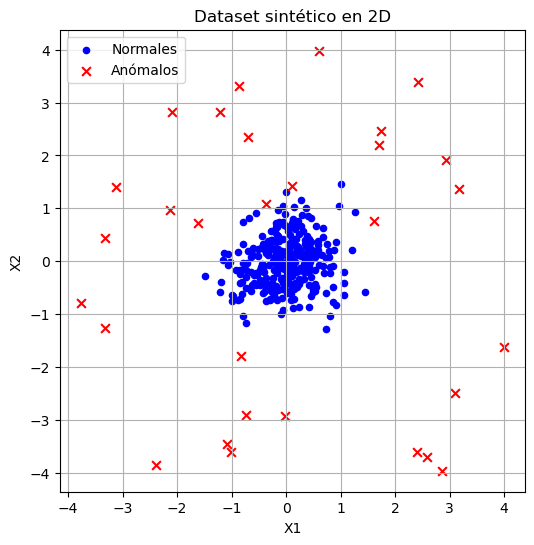

In [2]:
# Datos normales (gaussianos alrededor de 0,0)
X_norm = rng.normal(loc=0, scale=0.5, size=(300, 2))

# Anomalías (distribuidas más lejos)
X_anom = rng.uniform(low=-4, high=4, size=(30, 2))

# Conjunto completo
X = np.vstack([X_norm, X_anom])
y_true = np.hstack([np.zeros(len(X_norm)), np.ones(len(X_anom))])  # 0=normal, 1=anómalo

plt.figure(figsize=(6,6))
plt.scatter(X_norm[:,0], X_norm[:,1], c="blue", s=20, label="Normales")
plt.scatter(X_anom[:,0], X_anom[:,1], c="red", marker="x", s=40, label="Anómalos")
plt.legend(); plt.title("Dataset sintético en 2D"); plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


### Definición del Autoencoder

El modelo tendrá:
- **Encoder**: reduce de 2 → 1 dimensión.  
- **Decoder**: reconstruye de 1 → 2 dimensiones.  


In [3]:
class SimpleAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = SimpleAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Entrenamiento

Entrenamos únicamente con los datos normales para que el modelo aprenda a reproducir esa distribución.  


In [4]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)
X_tensor = torch.tensor(X_train, dtype=torch.float32)

for epoch in range(300):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()


### Error de reconstrucción

Calculamos el error de reconstrucción en normales y anomalías.  


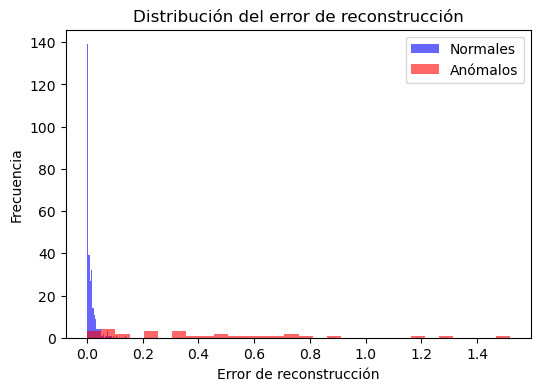

In [5]:
X_all = scaler.transform(X)
X_tensor_all = torch.tensor(X_all, dtype=torch.float32)

with torch.no_grad():
    recon_all = model(X_tensor_all)
    errors = torch.mean((X_tensor_all - recon_all)**2, dim=1).numpy()

plt.figure(figsize=(6,4))
plt.hist(errors[y_true==0], bins=30, alpha=0.6, label="Normales", color="blue")
plt.hist(errors[y_true==1], bins=30, alpha=0.6, label="Anómalos", color="red")
plt.xlabel("Error de reconstrucción"); plt.ylabel("Frecuencia")
plt.title("Distribución del error de reconstrucción")
plt.legend(); plt.show()


Los normales presentan errores bajos, mientras que las anomalías quedan desplazadas hacia errores más altos.  
El modelo no sabe reconstruir lo que nunca vio en el entrenamiento.


### Representación latente

El encoder reduce los datos a una única variable.  
Podemos visualizar cómo quedan organizados normales y anómalos en este espacio comprimido.


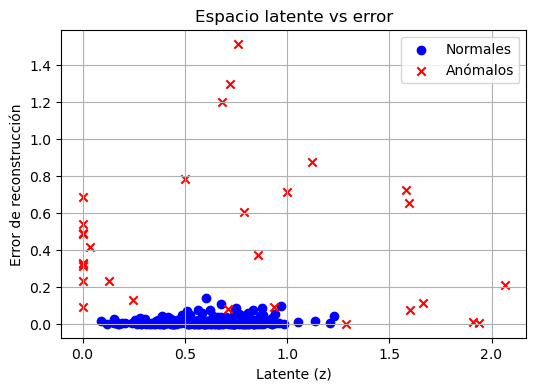

In [6]:
with torch.no_grad():
    z = model.encoder(X_tensor_all).numpy()

plt.figure(figsize=(6,4))
plt.scatter(z[y_true==0], errors[y_true==0], c="blue", label="Normales")
plt.scatter(z[y_true==1], errors[y_true==1], c="red", marker="x", label="Anómalos")
plt.xlabel("Latente (z)"); plt.ylabel("Error de reconstrucción")
plt.title("Espacio latente vs error")
plt.legend(); plt.grid(True); plt.show()


Se observa cómo los puntos normales forman una estructura compacta en el espacio latente,  
mientras que los anómalos aparecen más dispersos y con errores mayores.


### Señales temporales con fallo puntual

Otra forma de ver la utilidad de los Autoencoders es con series correlacionadas.  
Cuando las señales se comportan de forma predecible entre sí, el modelo puede reconstruirlas bien.  
Si en un intervalo se rompe esa relación, el error aumenta.


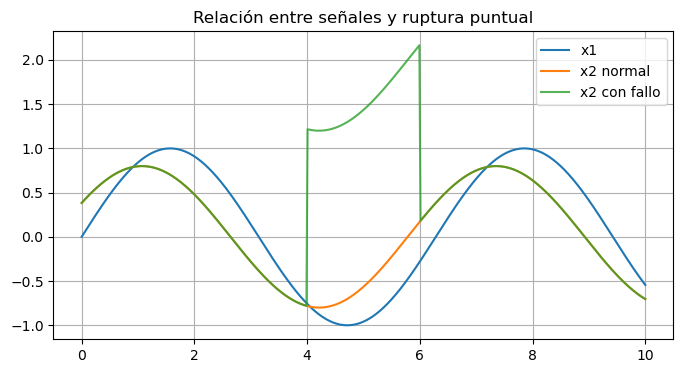

In [7]:
# Señales correlacionadas
t = np.linspace(0, 10, 500)
x1 = np.sin(t)
x2 = np.sin(t + 0.5) * 0.8

# Introducimos un fallo en x2 durante un intervalo
x2_fault = x2.copy()
x2_fault[200:300] += 2.0

X_norm = np.vstack([x1, x2]).T
X_anom = np.vstack([x1, x2_fault]).T

plt.figure(figsize=(8,4))
plt.plot(t, x1, label="x1")
plt.plot(t, x2, label="x2 normal")
plt.plot(t, x2_fault, label="x2 con fallo", alpha=0.8)
plt.title("Relación entre señales y ruptura puntual")
plt.legend(); plt.grid(True); plt.show()


Entrenamos el Autoencoder sobre las señales normales

In [8]:
class AE_Signals(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Normalizamos y entrenamos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
model = AE_Signals()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(300):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()


Evaluamos cómo el autoencoder reconstruye tanto las señales normales como las anómalas

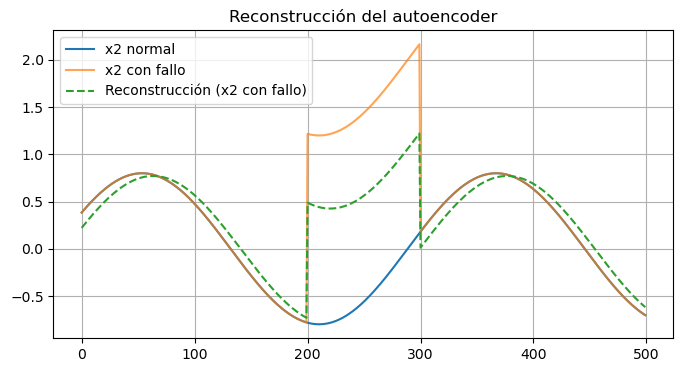

In [9]:
# Transformamos datos con fallo
X_all = np.vstack([X_norm, X_anom])
X_scaled = scaler.transform(X_all)
X_tensor_all = torch.tensor(X_scaled, dtype=torch.float32)

with torch.no_grad():
    recon_all = model(X_tensor_all).numpy()

# Reconstrucción de la parte con fallo
recon_norm = recon_all[:len(X_norm)]
recon_fault = recon_all[len(X_norm):]

plt.figure(figsize=(8,4))
plt.plot(x2, label="x2 normal")
plt.plot(x2_fault, label="x2 con fallo", alpha=0.7)
plt.plot(scaler.inverse_transform(recon_fault)[:,1], 
         label="Reconstrucción (x2 con fallo)", linestyle="--")
plt.title("Reconstrucción del autoencoder")
plt.legend(); plt.grid(True); plt.show()


El error debería permanecer bajo en los segmentos normales y subir en el intervalo del fallo.

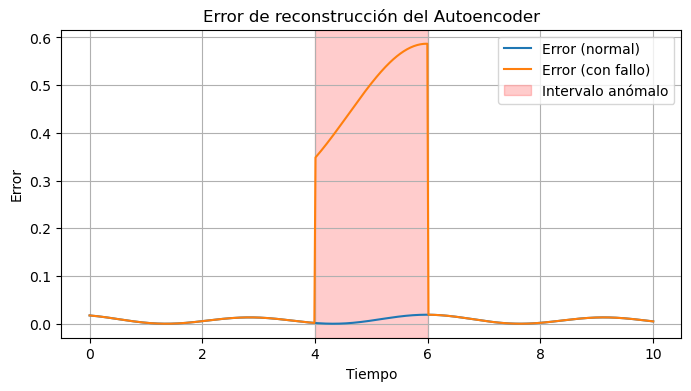

In [10]:
with torch.no_grad():
    errors = ((X_tensor_all.numpy() - recon_all)**2).mean(axis=1)

errors_norm = errors[:len(X_norm)]
errors_fault = errors[len(X_norm):]

plt.figure(figsize=(8,4))
plt.plot(t, errors_norm, label="Error (normal)")
plt.plot(t, errors_fault, label="Error (con fallo)")
plt.axvspan(t[200], t[300], color="red", alpha=0.2, label="Intervalo anómalo")
plt.title("Error de reconstrucción del Autoencoder")
plt.xlabel("Tiempo"); plt.ylabel("Error")
plt.legend(); plt.grid(True); plt.show()


En este escenario, el Autoencoder entrenado con las señales normales no logra reconstruir bien el intervalo donde la correlación se rompe, generando un error de reconstrucción elevado en ese segmento.
